In [1]:
import traceback
import sys
import logging
import os
import json
import xml.etree.ElementTree as ET 
import calendar
from pathlib import Path
from zipfile import ZipFile 
import shutil
import uuid
import concurrent.futures
import time
import datetime

from delta import *
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.types import StructType

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def init_logging() -> Tuple[logging.Logger, str]:
    """Instantiates the python logger and gets a uuid for this run

    Returns
    logger (logging.Logger): The configured logger
    u (str(UUID)): The uuid as a string
    """
    u = str(uuid.uuid4())
    log_file = f"./logs/{u}.log"
    logging.basicConfig(filename=log_file,
                        filemode='a',
                        format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG)
    
    logging.info("Starting Tiny Town Police Department Analytics Engine")
    logger = logging.getLogger(__name__)
    return logger, u

In [3]:
def get_spark_session() -> SparkSession:
    """Retrieves or creates an active Spark Session for Delta operations
    
    Returns:
        spark (SparkSession): the active Spark Session
    """
    builder = SparkSession \
        .builder \
        .appName('takehome') \
        .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
        .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
    spark = configure_spark_with_delta_pip(builder).getOrCreate()    
    spark.sparkContext.setLogLevel("ERROR")
    return spark

In [4]:
def stage_data() -> None:
    """Unzips the .zip and splits up the datasources into sub-dirs in the ttpd_data dir

    Does Not Return: Could also be accomplished with a bash script using find and using subprocess.run()
    """
    if os.path.isdir("./ttpd_data"):
        shutil.rmtree("./ttpd_data")
    with ZipFile("./ttpd_data.zip", "r") as z:
        z.extractall(path="./")
    os.makedirs("./ttpd_data/people")    
    os.makedirs("./ttpd_data/speeding")
    os.makedirs("./ttpd_data/automobiles")
    source_map={".csv":"people", ".json":"speeding", ".xml":"automobiles"}    
    files = Path("./ttpd_data").glob("*")
    for file in files:
        f_base= os.path.basename(file)
        _, f_ext = os.path.splitext(file)
        if f_ext:
            new_dir = f"./ttpd_data/{source_map[f_ext]}/{f_base}"     
            shutil.move(file, new_dir)
    shutil.rmtree("./__MACOSX")     

In [5]:
def load_people_df(peopleDir:str=None) -> DataFrame:
    """Loads the peoples datasource from pipe delimited csvs into a dataframe.
    Hardcoded the landing dir for now but left open the possibility of having alternates

    Parameters:
        peopleDir (str): people data directory. defaults to None and is overwritten if so. Added for future-proofing and the dir changes

    Returns:
        peopleDf (DataFrame): either the people dataframe or an empty one
    """
    if not peopleDir:        
        peopleDir = "./ttpd_data/people"
    if not os.path.exists(peopleDir):
        return spark.createDataFrame(spark.sparkContext.emptyRDD(), schema = StructType([]))
    peopleDf = spark.read.csv(peopleDir, header=True, inferSchema=True, sep="|")
    
    return peopleDf

In [6]:
def load_speeding_df(speedingDir=None) -> DataFrame:
    """Loads the speeding datasource from json into a dataframe

    Parameters:
        speedingDir (str): speeding data directory. defaults to None and is overwritten if so. Added for future-proofing and the dir changes

    Returns:
        speedingDf (DataFrame): either the speeding dataframe or an empty one
    """
    if not speedingDir:        
        speedingDir = "./ttpd_data/speeding"
    if not os.path.exists(speedingDir):
        return spark.createDataFrame(spark.sparkContext.emptyRDD(), schema = StructType([]))
        
    files = Path(speedingDir).glob("*.json")
    speedingData=[]
    for f in files:
        with open(f, 'r') as j:
            data=json.load(j)
            speedingData.append(json.dumps(data['speeding_tickets']))
    speedingDf=spark.read.json(spark.sparkContext.parallelize(speedingData))
    
    return speedingDf

In [7]:
def load_auto_df(autoDir=None, columns:List[str]=None) -> DataFrame:
    """Loads the automobile datasource from xml to a dataframe. Parses each file 1 by 1 appending to a list of lists then creating a dataframe from it.
    was having trouble getting the databricks jar to work nicely to load an xml file directly into Spark. Whipped this up to handle things instead.

    Parameters:
        autoDir (str): auto data directory. defaults to None and is overwritten if so. Added for future-proofing and the dir changes
        columns (List[str]): the xml we want to parse out. defaults to None and is overwritten if so. Added for future-proofing and the dir changes

    Inner Functions:
        parseXML(): do the xml parsing and return a list of lists

    Returns:
        autoDf (DataFrame): either the speeding dataframe or an empty one
    """
    def parseXML(xmlfile:str, columns:List[str]) -> List[List[str]]: 
        """An xml file parser, highly customized to this problemset.

        Parameters:
            xmlfile (str): The path of an xml file to be parsed
            columns (List[str]): A list of xml tags we want to extract and determinisitically enforce their existance

        Returns:
            data (List[List[str]]): A list of lists, each sublist containing one automobile tag from the xml
        """
        root = ET.parse(xmlfile) 
        data = []
        empty_line = {}
        for c in columns:
            empty_line[c] = None
        line = empty_line
        for child in root.iter():
            if child.tag == 'automobiles':
                continue
            if child.tag == 'automobile':
                # the first iteration will add a [None]. This check stops that
                if line["person_id"]:
                # if line[0]:
                    data.append(list(line.values()))
                line = empty_line
            else:
                if child.tag not in columns:
                    raise Exception("Malformed XML which will break parsing")
                line[child.tag] = child.text
                
        return data
        
    if not autoDir:        
        autoDir = './ttpd_data/automobiles'
    if not os.path.exists(autoDir):
        return spark.createDataFrame(spark.sparkContext.emptyRDD(), schema = StructType([]))
    if not columns:        
        columns = ["person_id", "license_plate", "vin", "color", "year"]
        
    files = Path(autoDir).glob("*.xml")
    xmlData=[]
    for f in files:
        xmlData += parseXML(f, columns)
    autoDf = spark.createDataFrame(xmlData, columns)

    return autoDf

In [8]:
def load_data() -> Tuple[DataFrame, DataFrame, DataFrame]:
    """Attempts to load each of the three datasets and panics if any one shows up empty

    Returns:
        peopleDf (DataFrame): the people dataset
        speedingDf (DataFrame): the speeding dataset
        autoDf (DataFrame): the automobiles dataset
    """

    # Making this data load happen concurrently PJS 5/7/2024
    with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
        f_people = executor.submit(load_people_df)
        f_speeding = executor.submit(load_speeding_df)
        f_auto = executor.submit(load_auto_df)
        
        peopleDf = f_people.result()
        speedingDf = f_speeding.result()
        autoDf = f_auto.result()
        
    if peopleDf.isEmpty():
        raise Exception("People DataFrame is Empty!")
    if speedingDf.isEmpty():
        raise Exception("Speeding DataFrame is Empty!")
    if autoDf.isEmpty():
        raise Exception("Automobiles DataFrame is Empty!")
        
    return peopleDf, speedingDf, autoDf

In [9]:
def question_one(peopleDf:DataFrame, speedingDf:DataFrame) -> str:
    """Answers the first question

    Parameters:
        peopleDf (DataFrame): the people dataset
        speedingDf (DataFrame): the speeding dataset

    Returns:
        (str): the analysis of question one
    """
    policeDf = peopleDf.where("profession = 'Police Officer'")
    officer_grouped = speedingDf.groupBy("officer_id").agg(count("id").alias("ticket_count"))
    max_val=officer_grouped.agg(max("ticket_count")).collect()[0][0]
    res= officer_grouped.filter(col("ticket_count") == max_val)
    joinedDF= res.join(policeDf, res.officer_id == policeDf.id, "inner").select("first_name", "last_name", "ticket_count")

    # naive get max val then get index of max val approach can return multiple rows if theres a tie for first
    # create a test case for this
    officers=[]
    for row in joinedDF.collect():
        officers.append(f"{row['first_name']} {row['last_name']}")
    out_officers = ','.join(officers)
    return f"Officer(s) {out_officers} distributed the most speeding tickets: {row['ticket_count']}"

In [10]:
def question_two(speedingDf:DataFrame) -> Tuple[str, DataFrame]:
    """Answers the second question

    Parameters:
        speedingDf (DataFrame): the speeding dataset

    Returns:
        stout (str): the analysis of question two
    """
    speedingDf = speedingDf.withColumn("yyyymm", regexp_replace(substring("ticket_time", 0,7), '-', ''))
    time_grouped = speedingDf.groupBy("yyyymm").agg(count("id").alias("ticket_count"))
    out= time_grouped.sort("ticket_count", ascending=False).take(3)
    stout= 'These are the top three months by total tickets written\n\t'
    for row in out:
        stout += f"{calendar.month_name[int(row['yyyymm'][4:6])]} {row['yyyymm'][:4]}: {row['ticket_count']} Tickets Written\n\t"
    return stout[:-2]

In [11]:
@udf(returnType=LongType())
def calc_ticket_cost(school_zone_ind:bool, work_zone_ind:bool) -> int:
    """A spark sql user defined function (udf) to calculate a tickets cost to the driver.

    Parameters:
        school_zone_ind (bool): 1 if school 0 if not
        work_zone_ind(bool): 1 if work 0 if not            

    Returns:
        cost (int): the resultng cost of the ticket
    """
    # this would be replaced with a call to some API in production, hardcoded for now
    ticket_config = {'base':30, 'school':60, 'work': 60, 'school+work':120}
    if not ticket_config:
        raise Exception ("can't access ticket price database")

    cost = ticket_config['base']
    if school_zone_ind:
        cost += ticket_config['school']
    if work_zone_ind:
        cost += ticket_config['work']
    if school_zone_ind and work_zone_ind:
        cost = ticket_config['school+work']
        
    return cost

In [12]:
def question_three(peopleDf:DataFrame, speedingDf:DataFrame, autoDf:DataFrame) -> Tuple[str, DataFrame]:
    """Answers the third question

    Parameters:
        peopleDf (DataFrame): the people dataset
        speedingDf (DataFrame): the speeding dataset
        autoDf (DataFrame): the automobiles dataset

    Returns:
        stout (str): the analysis of question three
    """       
    speedingDf = speedingDf.withColumn('ticket_cost', calc_ticket_cost('school_zone_ind', 'work_zone_ind'))
    all_joined = autoDf.join(speedingDf, autoDf.license_plate == speedingDf.license_plate, "inner") \
                .join(peopleDf, peopleDf.id == autoDf.person_id, "inner") \
                .select(autoDf.person_id, speedingDf.ticket_cost) 
    person_grouped = all_joined.groupBy("person_id").agg(sum("ticket_cost").alias("total_ticketed_amount"))
    pg=person_grouped.alias("pg")
    res = pg.join(peopleDf, peopleDf.id == pg.person_id, "inner").orderBy("total_ticketed_amount", ascending=False)
    out=res.select("first_name", "last_name", "total_ticketed_amount").take(10)
    
    stout= 'These are the top ten most ticketed drivers by total ticket dollars levied\n\t'
    for row in out:
        stout += f"{row['first_name']} {row['last_name']}: ${row['total_ticketed_amount']}\n\t"
    return stout[:-2]

In [13]:
def bonus(speedingDf:DataFrame) -> str:
    """Answers the bonus question

    Parameters:
        speedingDf (DataFrame): the speeding dataset

    Returns:
        res (str): the analysis of the bonus question 
    """
    speedingDf = speedingDf.withColumn('ticket_cost', calc_ticket_cost('school_zone_ind', 'work_zone_ind'))
    speedingDf = speedingDf.withColumn("year", date_trunc("year", "ticket_time"))                                       
    speedingDf = speedingDf.withColumn("month", date_trunc("month", "ticket_time"))
    yyyymm_grouped = speedingDf.groupBy("month").agg(count("id").alias("ticket_count"))    
    yyyy_grouped = speedingDf.groupBy("year").agg(count("id").alias("ticket_count"))

    pd_yyyymm = yyyymm_grouped.toPandas()
    pd_yyyymm["month"] = pd.to_datetime(pd_yyyymm["month"])
    pd_yyyymm.set_index("month", inplace=True, drop=True)
    pd_yyyymm.sort_index(inplace=True)
    pd_yyyy = yyyy_grouped.toPandas()
    pd_yyyy["year"] = pd.to_datetime(pd_yyyy["year"])
    pd_yyyy.set_index("year", inplace=True, drop=True)
    pd_yyyy.sort_index(inplace=True)
    
    if run_type == "python" or not verbose:
        matplotlib.use('agg')
    fig, axs = plt.subplots(2, figsize=(30, 15))
    plt.ioff()
    axs[0].set(xlabel="Year and Month",
       ylabel="Total Tickets Written",
       title="Month over Month Speeding Tickets\nTiny Town Police Department 2020-2023")
    
    axs[1].set(xlabel="Year",
       ylabel="Total Tickets Written",
       title="Year over Year Speeding Tickets\nTiny Town Police Department 2020-2023")

    plt.setp(axs[0].get_xticklabels(), rotation=45)
    plt.setp(axs[1].get_xticklabels(), rotation=45)
    pd_yyyymm.plot.bar(ax=axs[0], y="ticket_count")
    pd_yyyy.plot.bar(ax=axs[1], y="ticket_count")
    plt.tight_layout()
    plt.savefig(f'./img/{u}.png', bbox_inches='tight')
    if verbose and run_type == "jupyter":
        plt.show()
    plt.close(fig)
    res = """
        Looking year-over-year, the number of tickets written increases over time.
         Drilling down and looking month-over-month, the number of tickets written follows a seasonal pattern.
         - There first is a slight spike at the beginning of the year, just in January.
         - Numbers dwindle as Winter gives way to Spring but begin to tick back up when the weather warms up. 
             - May is the start of the Summer increase, which see's its peak around July, then tapers down through September and fully wanes through the advent of Autumn.
         - The end of the year, as evidenced by the prior Top Three Months analysis, is where the lions share of tickets are written. 
             - December ranks in as either the highest or second highest month of each year by volume, potentially indicating the use of an annualized ticket quota system 
             - Maybe a scramble to meet it before the year completes that carries on into the start of the year, followed by a Spring lull.
             - The Summer Swell could correlate with a mid-year goals check-in or just increased number of motorists driving/speeding in warmer weather.
    """

    return res

In [14]:
def answer_questions(peopleDf:DataFrame, speedingDf:DataFrame, autoDf:DataFrame) -> Tuple[str,str,str,str]:
    """Entrypoint to answer all questions concurrently

    Parameters:
        peopleDf (DataFrame): the people dataset
        speedingDf (DataFrame): the speeding dataset
        autoDf (DataFrame): the automobiles dataset

    Returns:
        q1: the analysis of question one
        q2: the analysis of question two
        q3: the analysis of question three
        b: the analysis of the bonus question 
    """

    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        f_1 = executor.submit(question_one, peopleDf, speedingDf)
        f_2 = executor.submit(question_two, speedingDf)
        f_3 = executor.submit(question_three, peopleDf, speedingDf, autoDf)
        f_b = executor.submit(bonus, speedingDf)
        
        q1 = f_1.result()
        q2 = f_2.result()
        q3 = f_3.result()
        b = f_b.result()

    return q1, q2, q3, b
    

In [15]:
def main() -> bool:
    """The main application entrypoint

    Returns:
        (bool): true if successful, false if not
    """          

    logger.info("Data Staging Start")
    t1 = time.perf_counter()
    try:
        stage_data()
    except Exception as e:
        logger.exception(e)
        t2 = time.perf_counter()
        s = f"Time Elapsed {t2 - t1:0.4f} seconds"
        msg = "Data Staging Failure, Killing App"
        return False
    else:
        t2 = time.perf_counter()
        s = f"Time Elapsed {t2 - t1:0.4f} seconds"
        msg = "Data Staging Success"
    finally:
        res = f"{msg}: {s}"
        logger.info(res)
        if verbose:
            print(res)
        
    
    logger.info("Data Load Start")
    t1 = time.perf_counter()
    try:
        peopleDf, speedingDf, autoDf = load_data()
    except Exception as e:
        logger.exception(e)
        t2 = time.perf_counter()
        s = f"Time Elapsed {t2 - t1:0.4f} seconds"
        msg = "Data Load Failure, Killing App"
        return False
    else:
        t2 = time.perf_counter()
        s = f"Time Elapsed {t2 - t1:0.4f} seconds"
        msg = "Data Load Success"
    finally:
        res = f"{msg}: {s}"
        logger.info(res)
        if verbose:
            print(res)
            

    logger.info("Questions Start")
    t1 = time.perf_counter()
    try:
        q1, q2, q3, b = answer_questions(peopleDf, speedingDf, autoDf)
    except Exception as e:
        logger.exception(e)
        t2 = time.perf_counter()
        s = f"Time Elapsed {t2 - t1:0.4f} seconds"
        msg = "Questions Failure, Killing App"
        return False
    else:
        t2 = time.perf_counter()
        s = f"Time Elapsed {t2 - t1:0.4f} seconds"
        msg = "Questions Success"
    finally:
        res = f"{msg}: {s}"
        logger.info(res)
        if verbose:
            print(res)

    spark.stop()
    
    output= f"""
    Tiny Town Police Department Ticketing Analysis:
    1. Which police officer was handed the most speeding tickets?
        {q1}
    2. What 3 months (year + month) had the most speeding tickets? 
        {q2}
    3. Using the ticket fee table below, who are the top 10 people who have spent the most money paying speeding tickets overall?
        {q3}
    Bonus: What overall month-by-month or year-by-year trends, if any, do you see?
        {b}
            """ 
    if verbose:
        print(output)
    with open(f"./out/{u}.txt", "w") as f:
        f.write(output)

    t1 = time.perf_counter()
    s = f"Time Elapsed {t1 - t0:0.4f} seconds"
    msg = "Successfully Completed"
    res = f"{msg}: {s}"
    logger.info(res)
    if verbose:
        print(res)

    return True

Time Start: 2024-05-08 13:00:57.771390


24/05/08 13:01:00 WARN Utils: Your hostname, Petes-OMEN-15 resolves to a loopback address: 127.0.1.1; using 172.31.102.236 instead (on interface eth0)
24/05/08 13:01:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/pete/miniconda3/envs/ttpd/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/pete/.ivy2/cache
The jars for the packages stored in: /home/pete/.ivy2/jars
io.delta#delta-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-88935cb2-599d-4fb4-b2fe-77334fc7800e;1.0
	confs: [default]
	found io.delta#delta-spark_2.12;3.1.0 in central
	found io.delta#delta-storage;3.1.0 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
:: resolution report :: resolve 206ms :: artifacts dl 10ms
	:: modules in use:
	io.delta#delta-spark_2.12;3.1.0 from central in [default]
	io.delta#delta-storage;3.1.0 from central in [default]
	org.antlr#antlr4-runtime;4.9.3 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   3   |   0   |

Spark init success: Time Elapsed 6.9969 seconds
Data Staging Success: Time Elapsed 4.6560 seconds


Data Load Success: Time Elapsed 8.4996 seconds


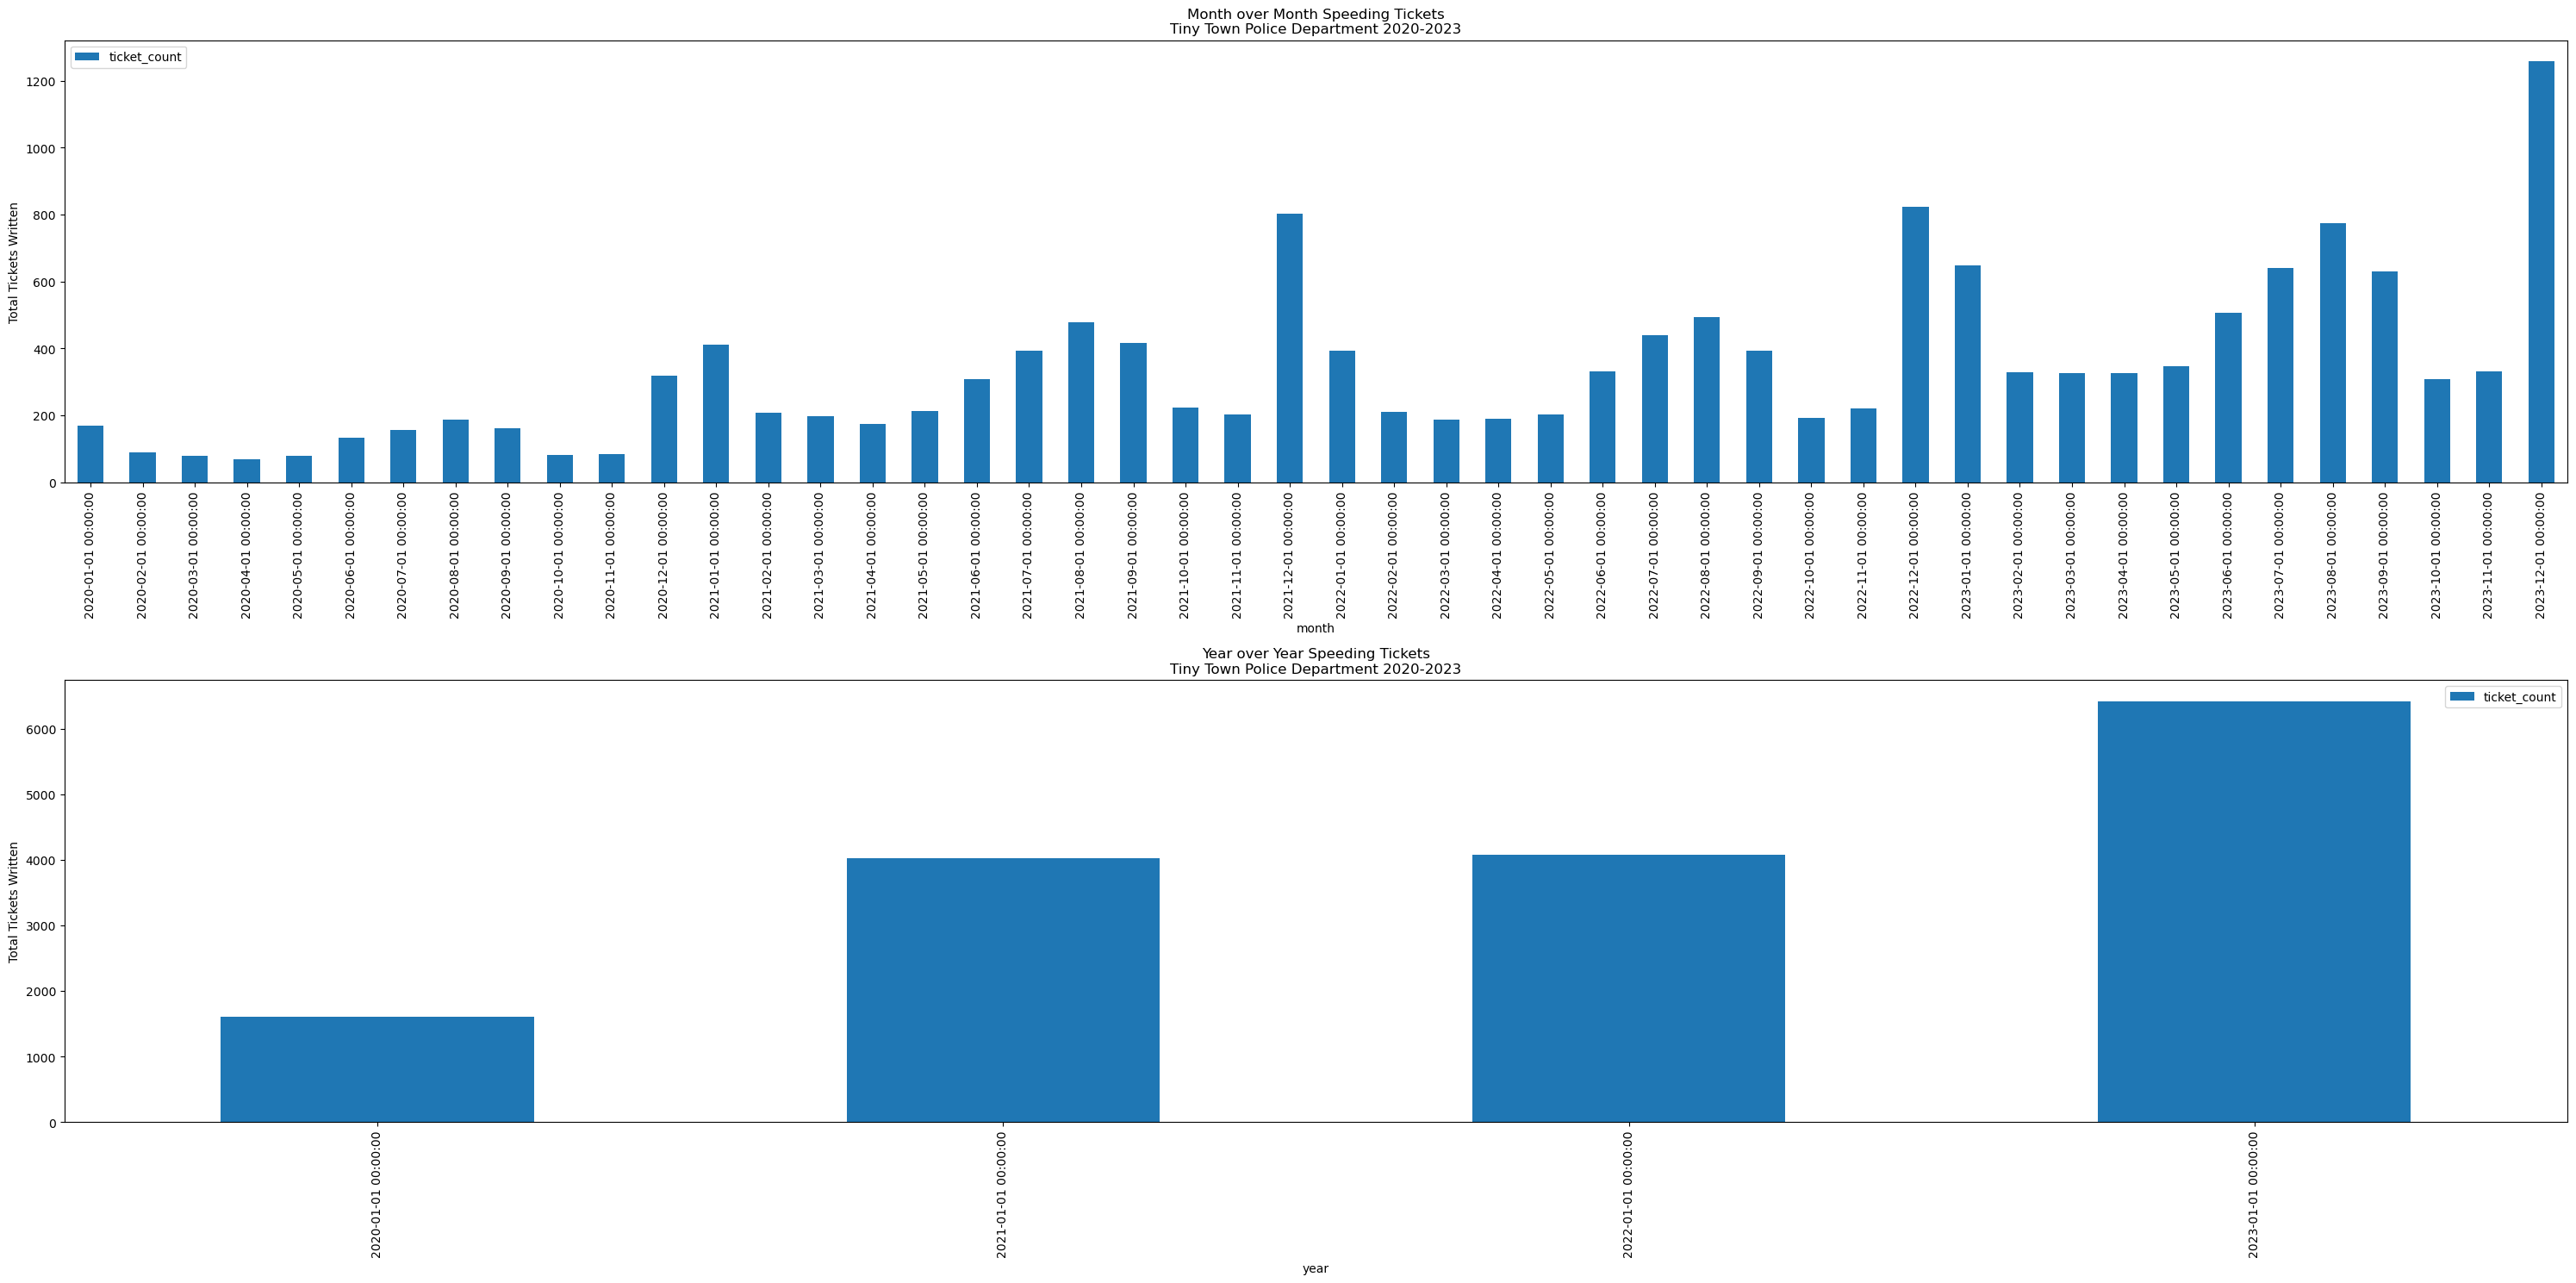

Questions Success: Time Elapsed 11.0650 seconds

    Tiny Town Police Department Ticketing Analysis:
    1. Which police officer was handed the most speeding tickets?
        Officer(s) Barbara Cervantes distributed the most speeding tickets: 419
    2. What 3 months (year + month) had the most speeding tickets? 
        These are the top three months by total tickets written
	December 2023: 1258 Tickets Written
	December 2022: 824 Tickets Written
	December 2021: 803 Tickets Written
    3. Using the ticket fee table below, who are the top 10 people who have spent the most money paying speeding tickets overall?
        These are the top ten most ticketed drivers by total ticket dollars levied
	Charles Dunn: $840
	Kimberly Mcdowell: $810
	Pamela Young: $810
	Carla Robinson: $780
	Ariel Smith: $750
	Adrian May: $720
	Jerry Little: $690
	Avery Smith: $660
	Tracy Casey: $660
	Patricia Zuniga: $660
    Bonus: What overall month-by-month or year-by-year trends, if any, do you see?
        
  

In [16]:
if __name__ == '__main__':
    global spark
    global u
    global verbose
    global run_type
    
    verbose = True
    run_type = "jupyter"
    
    try:
        logger, u = init_logging()
    except Exception as e:
        print(e)
        quit()
        
    t0 = time.perf_counter() 
    logger.info(f"Time Start: {datetime.datetime.now()}")
    if verbose:
        print(f"Time Start: {datetime.datetime.now()}")

    
    logger.info("Spark Init Start")
    t1 = time.perf_counter()
    try:
        spark: SparkSession= get_spark_session()
    except Exception as e:
        logger.exception(e)
        t2 = time.perf_counter()
        s = f"Time Elapsed {t2 - t1:0.4f} seconds"
        msg = "Spark Init Failure, Killing App"
        quit()
    else:
        t2 = time.perf_counter()
        s = f"Time Elapsed {t2 - t1:0.4f} seconds"
        msg = "Spark init success"
    finally:
        res = f"{msg}: {s}"
        logger.info(res)
        if verbose:
            print(res)

    res = main()

    if verbose:
        if res:
            print(f"Process finished successfully at {datetime.datetime.now()}")
        else:        
            print(f"Process failed at {datetime.datetime.now()}")